# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
 
from PIL import Image
import matplotlib.pyplot as plt
 
 
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

Found 7591 validated image filenames.


In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

In [2]:
labels.shape

(7591, 2)

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


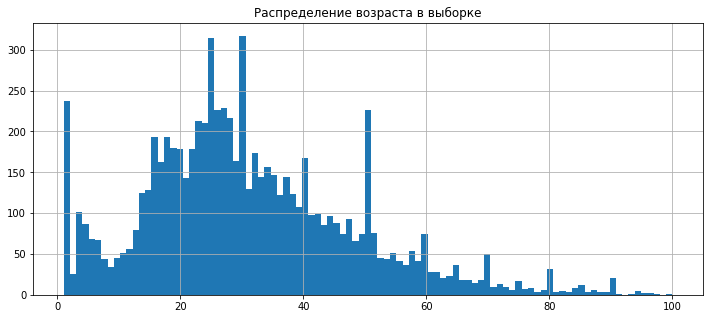

In [4]:
labels['real_age'].hist(bins = len(labels['real_age'].unique()), figsize = (12,5))

plt.title('Распределение возраста в выборке')
plt.show()

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
Для некоторых категорий возрастов фотографий значительно меньше. <br> 
График распределения близок к нормальному. <br>
В наборе данных представлено больше всего фотографий людей в возрасте от 10 до 50 лет. Данных фотографий других возрастов значительно меньше, что может негативно сказаться на качестве обучения. <br>    
</p>
</div>

In [6]:
features, target = next(train_gen_flow)

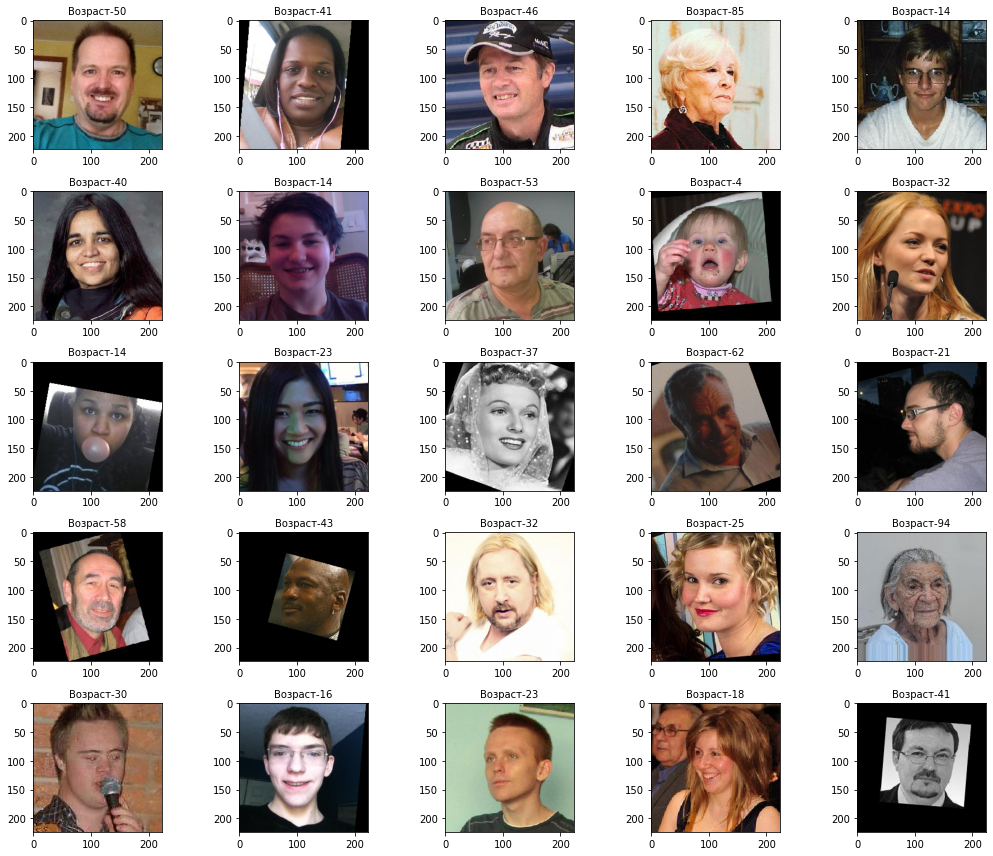

In [12]:
fig = plt.figure(figsize=(15,12))
plt.subplots_adjust(top=0.90, wspace=0.2, hspace=0.90)
for i in range(25):
    fig.add_subplot(5,5, i+1)
    plt.title(f'Возраст-{target[i]}', fontsize=10)
    plt.imshow(features[i])
    plt.grid(False)
plt.tight_layout()

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
Видим, что в наборе данных фотографий есть фотографии на черном фоне и повернутые на на разные углы наклона вправо и влево относительно оси Х, а также фотографии, сделанные под разным освещением, а также черно-белые фотографии. Такой разнообразный набор фотографий может оказать положительный эффект на качество обучения мдели, так как модель научится распознавать возраст на фотографиях под разнвм улом, с любым освещением, а также на черно-белых фотографиях.     
</p>
</div>

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path): 
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.
                                )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col="file_name", 
        y_col="real_age", 
        target_size=(224, 224),
        batch_size=64,
        class_mode='raw',
        subset='training',
        seed=12345)

    
    return train_datagen_flow

def load_test(path): 
    labels = pd.read_csv(path+'labels.csv')
    datagen_t = ImageDataGenerator(validation_split=0.25,rescale=1/255.)
    
    test_datagen_flow = datagen_t.flow_from_dataframe(
    dataframe=labels,
    directory=path+'final_files/',
    x_col='file_name',
    y_col='real_age',    
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)
  
    
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                       weights='imagenet',
                       include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(Conv2D(filters=6, 
                     kernel_size=(3, 3), 
                     input_shape=(224, 224, 3), 
                     padding='same', 
                     activation='relu'))
    model.add(AveragePooling2D())
    model.add(Flatten())

    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae']) 
    return model 

def train_model(
    model, 
    train_data, 
    test_data, 
    batch_size=None, 
    epochs=10, 
    steps_per_epoch=None, 
    validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(
        train_data, 
        validation_data=test_data, 
        steps_per_epoch=steps_per_epoch, 
        validation_steps=validation_steps, 
        batch_size=batch_size, 
        epochs=epochs, 
        verbose=2)
    return model

```

```

2023-02-23 13:16:57.785493: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-02-23 13:16:57.993789: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2023-02-23 13:17:03.912455: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-02-23 13:17:04.034207: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-23 13:17:04.034301: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-02-23 13:17:04.034334: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-23 13:17:04.108455: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-02-23 13:17:04.133889: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-02-23 13:17:04.459222: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-02-23 13:17:04.498715: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-02-23 13:17:04.498840: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-02-23 13:17:04.503414: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-02-23 13:17:04.904268: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-02-23 13:17:04.936089: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099995000 Hz
2023-02-23 13:17:04.938021: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4cf7cb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-02-23 13:17:04.938058: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-02-23 13:17:05.129705: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4357fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-23 13:17:05.129747: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-02-23 13:17:05.132139: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-23 13:17:05.132202: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-02-23 13:17:05.132212: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-23 13:17:05.132241: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-02-23 13:17:05.132251: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-02-23 13:17:05.132259: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-02-23 13:17:05.132269: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-02-23 13:17:05.132276: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-02-23 13:17:05.136965: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-02-23 13:17:05.138762: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-02-23 13:17:08.506029: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-02-23 13:17:08.506073: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-02-23 13:17:08.506082: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-02-23 13:17:08.510589: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-23 13:17:08.510641: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 1s
   65536/94765736 [..............................] - ETA: 1:14
  262144/94765736 [..............................] - ETA: 41s 
  729088/94765736 [..............................] - ETA: 21s
 1974272/94765736 [..............................] - ETA: 10s
 4218880/94765736 [>.............................] - ETA: 5s 
 8462336/94765736 [=>............................] - ETA: 3s
12828672/94765736 [===>..........................] - ETA: 2s
16490496/94765736 [====>.........................] - ETA: 2s
20594688/94765736 [=====>........................] - ETA: 1s
25100288/94765736 [======>.......................] - ETA: 1s
28884992/94765736 [========>.....................] - ETA: 1s
32612352/94765736 [=========>....................] - ETA: 1s
37240832/94765736 [==========>...................] - ETA: 1s
41197568/94765736 [============>.................] - ETA: 0s
44744704/94765736 [=============>................] - ETA: 0s
48840704/94765736 [==============>...............] - ETA: 0s
53223424/94765736 [===============>..............] - ETA: 0s
56991744/94765736 [=================>............] - ETA: 0s
60686336/94765736 [==================>...........] - ETA: 0s
65241088/94765736 [===================>..........] - ETA: 0s
69214208/94765736 [====================>.........] - ETA: 0s
72810496/94765736 [======================>.......] - ETA: 0s
77176832/94765736 [=======================>......] - ETA: 0s
81543168/94765736 [========================>.....] - ETA: 0s
85147648/94765736 [=========================>....] - ETA: 0s
89055232/94765736 [===========================>..] - ETA: 0s
93380608/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 89 steps, validate for 60 steps
Epoch 1/10
2023-02-23 13:17:34.539447: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-23 13:17:36.795640: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-02-23 13:17:44.466787: W tensorflow/core/common_runtime/bfc_allocator.cc:243] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-23 13:17:44.466844: W tensorflow/core/common_runtime/bfc_allocator.cc:243] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
89/89 - 69s - loss: 188.2834 - mae: 10.0493 - val_loss: 877.9638 - val_mae: 24.7421
Epoch 2/10
89/89 - 39s - loss: 45.1082 - mae: 5.0664 - val_loss: 808.0862 - val_mae: 23.4950
Epoch 3/10
89/89 - 39s - loss: 16.8564 - mae: 3.0282 - val_loss: 679.0667 - val_mae: 20.7679
Epoch 4/10
89/89 - 39s - loss: 12.1392 - mae: 2.3964 - val_loss: 484.4271 - val_mae: 16.4976
Epoch 5/10
89/89 - 39s - loss: 9.3398 - mae: 2.1179 - val_loss: 397.6264 - val_mae: 14.7030
Epoch 6/10
89/89 - 39s - loss: 6.9437 - mae: 1.9295 - val_loss: 268.8740 - val_mae: 11.9687
Epoch 7/10
89/89 - 39s - loss: 6.0578 - mae: 1.7548 - val_loss: 152.2972 - val_mae: 9.4659
Epoch 8/10
89/89 - 40s - loss: 5.4439 - mae: 1.6440 - val_loss: 126.0370 - val_mae: 8.4418
Epoch 9/10
89/89 - 39s - loss: 4.8801 - mae: 1.5683 - val_loss: 86.9972 - val_mae: 7.1155
Epoch 10/10
89/89 - 39s - loss: 4.4583 - mae: 1.5336 - val_loss: 81.1780 - val_mae: 6.8585
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 81.1780 - mae: 6.8585
Test MAE: 6.8585

```

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
Получили Test MAE: 6.8585. <br> 
Цель проекта достигнута, MAE модели не больше 8.    
</p>
</div>

## Анализ обученной модели

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
Для решения задачи и построения модели использовалась сеть с архитектурой RestNet50, с количеством эпох 10. <br>
<br>    
Для некоторых категорий возрастов фотографий значительно меньше. <br> 
График распределения близок к нормальному. <br>
В наборе данных представлено больше всего фотографий людей в возрасте от 10 до 50 лет. Данных фотографий других возрастов значительно меньше, что может негативно сказаться на качестве обучения. <br>  
В наборе данных фотографий есть фотографии на черном фоне и повернутые на на разные углы наклона вправо и влево относительно оси Х, а также фотографии, сделанные под разным освещением, а также черно-белые фотографии. Такой разнообразный набор фотографий может оказать положительный эффект на качество обучения мдели, так как модель научится распознавать возраст на фотографиях под разнвм улом, с любым освещением, а также на черно-белых фотографиях. <br>       
<br>
Цель проекта достигнута, MAE модели не больше 8.    
</p>
</div>